In [ ]:
# =========================================
# CELL 1 — Install + download model (run once per runtime)
# =========================================
!pip -q install mediapipe opencv-python

import os
if not os.path.exists("pose_landmarker_heavy.task"):
    !wget -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

!ls -lh pose_landmarker_heavy.task

-rw-r--r-- 1 root root 30M Apr 28  2023 pose_landmarker_heavy.task


In [ ]:
# =========================================
# CELL 2 — Imports + Pose detector
# =========================================
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow

from mediapipe.tasks import python
from mediapipe.tasks.python import vision

def make_pose_detector(model_path="pose_landmarker_heavy.task"):
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,
    num_poses=1
)
    return vision.PoseLandmarker.create_from_options(options)

detector = make_pose_detector("pose_landmarker_heavy.task")

In [ ]:
# =========================================
# CELL 2 — Imports + Pose detector
# =========================================
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

def make_pose_detector(model_path="pose_landmarker_heavy.task"):
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        num_poses=1
    )
    return vision.PoseLandmarker.create_from_options(options)

detector = make_pose_detector("pose_landmarker_heavy.task")
print("✅ detector created")

✅ detector created


In [ ]:
# =========================================
# CELL 3 — Feature extraction (StyleLab signals)
# =========================================
import math

# MediaPipe Pose indices
NOSE = 0
LEFT_SHOULDER, RIGHT_SHOULDER = 11, 12
LEFT_ELBOW, RIGHT_ELBOW = 13, 14
LEFT_WRIST, RIGHT_WRIST = 15, 16
LEFT_HIP, RIGHT_HIP = 23, 24
LEFT_KNEE, RIGHT_KNEE = 25, 26
LEFT_ANKLE, RIGHT_ANKLE = 27, 28

def _xy(lms, i):
    return np.array([lms[i].x, lms[i].y], dtype=np.float32)

def _dist(a, b):
    return float(np.linalg.norm(a - b))

def _mid(a, b):
    return (a + b) / 2.0

def _safe_div(a, b, eps=1e-9):
    return float(a) / float(b + eps)

def _angle(a, b, c):
    """Angle ABC in degrees with b as vertex."""
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba) * np.linalg.norm(bc)) + 1e-9
    cosang = np.clip(np.dot(ba, bc) / denom, -1.0, 1.0)
    return float(np.degrees(np.arccos(cosang)))

def _slope_abs(a, b):
    """Absolute slope magnitude of line AB in normalized coords."""
    dx = float(b[0] - a[0])
    dy = float(b[1] - a[1])
    return abs(_safe_div(dy, dx))

def extract_stylelab_features(pose_landmarks):
    """
    Returns the 4 requested features:
      - body_aspect_ratio: long vs compact read
      - torso_leg_ratio: where length lives
      - shoulder_hip_ratio: where visual weight is
      - joint_softness: sharp vs soft lines harmony (pose-geometry proxy; 0..1)
    """
    lms = pose_landmarks

    # Key points
    NO = _xy(lms, NOSE)

    LS, RS = _xy(lms, LEFT_SHOULDER), _xy(lms, RIGHT_SHOULDER)
    LH, RH = _xy(lms, LEFT_HIP), _xy(lms, RIGHT_HIP)
    LA, RA = _xy(lms, LEFT_ANKLE), _xy(lms, RIGHT_ANKLE)

    LE, RE = _xy(lms, LEFT_ELBOW), _xy(lms, RIGHT_ELBOW)
    LW, RW = _xy(lms, LEFT_WRIST), _xy(lms, RIGHT_WRIST)

    LK, RK = _xy(lms, LEFT_KNEE), _xy(lms, RIGHT_KNEE)

    shoulder_width = _dist(LS, RS)
    hip_width = _dist(LH, RH)

    shoulder_mid = _mid(LS, RS)
    hip_mid = _mid(LH, RH)
    ankle_mid = _mid(LA, RA)

    # 1) body_aspect_ratio (height/width proxy)
    height_proxy = _dist(NO, ankle_mid)
    width_proxy = max(shoulder_width, hip_width)
    body_aspect_ratio = _safe_div(height_proxy, width_proxy)

    # 2) torso_leg_ratio (where length lives)
    torso_len = _dist(shoulder_mid, hip_mid)
    leg_len = _dist(hip_mid, ankle_mid)
    torso_leg_ratio = _safe_div(torso_len, leg_len)

    # 3) shoulder_hip_ratio (visual weight)
    shoulder_hip_ratio = _safe_div(shoulder_width, hip_width)

    # 4) joint_softness proxy (0..1)
    left_elbow_ang = _angle(LS, LE, LW)
    right_elbow_ang = _angle(RS, RE, RW)
    left_knee_ang = _angle(LH, LK, LA)
    right_knee_ang = _angle(RH, RK, RA)

    # Normalize angles: 90° -> 0, 180° -> 1
    def norm_open(angle_deg):
        return float(np.clip((angle_deg - 90.0) / 90.0, 0.0, 1.0))

    angle_openness = np.mean([
        norm_open(left_elbow_ang),
        norm_open(right_elbow_ang),
        norm_open(left_knee_ang),
        norm_open(right_knee_ang),
    ])

    shoulder_slope = _slope_abs(LS, RS)
    hip_slope = _slope_abs(LH, RH)

    # Slope -> softness: 0 slope = 1 soft, >=1 slope ~0 soft (tunable)
    def slope_to_soft(s):
        return float(np.clip(1.0 - s, 0.0, 1.0))

    line_softness = np.mean([slope_to_soft(shoulder_slope), slope_to_soft(hip_slope)])
    joint_softness = float(np.clip(0.6 * angle_openness + 0.4 * line_softness, 0.0, 1.0))

        # -------------------------------
    # Reliability + safety rails
    # -------------------------------

    # Confidence flags (simple MVP gates)
    shoulder_hip_confident = (shoulder_hip_ratio <= 1.35)
    body_aspect_confident  = (2.4 <= body_aspect_ratio <= 4.2)
    torso_leg_confident    = (0.45 <= torso_leg_ratio <= 0.75)

    # Clamp extreme outliers (prevents crazy outputs)
    shoulder_hip_ratio_clamped = float(np.clip(shoulder_hip_ratio, 0.70, 1.40))
    body_aspect_ratio_clamped  = float(np.clip(body_aspect_ratio, 2.20, 4.50))
    torso_leg_ratio_clamped    = float(np.clip(torso_leg_ratio, 0.40, 0.85))
    joint_softness_clamped     = float(np.clip(joint_softness, 0.0, 1.0))

    return {
        # Use clamped values for downstream logic
        "body_aspect_ratio": body_aspect_ratio_clamped,
        "torso_leg_ratio": torso_leg_ratio_clamped,
        "shoulder_hip_ratio": shoulder_hip_ratio_clamped,
        "joint_softness": joint_softness_clamped,

        # Keep raw values for debugging
        "raw": {
            "body_aspect_ratio": float(body_aspect_ratio),
            "torso_leg_ratio": float(torso_leg_ratio),
            "shoulder_hip_ratio": float(shoulder_hip_ratio),
            "joint_softness": float(joint_softness),
        },

        # Confidence flags for decision-making / UI messaging
        "confidence": {
            "body_aspect_ratio": bool(body_aspect_confident),
            "torso_leg_ratio": bool(torso_leg_confident),
            "shoulder_hip_ratio": bool(shoulder_hip_confident),
            "joint_softness": True,  # usually stable; tune later if you want
        }
    }

Saving 5c22dea1-97fa-4ea7-9922-a67a4921d30e.jpeg to 5c22dea1-97fa-4ea7-9922-a67a4921d30e (2).jpeg


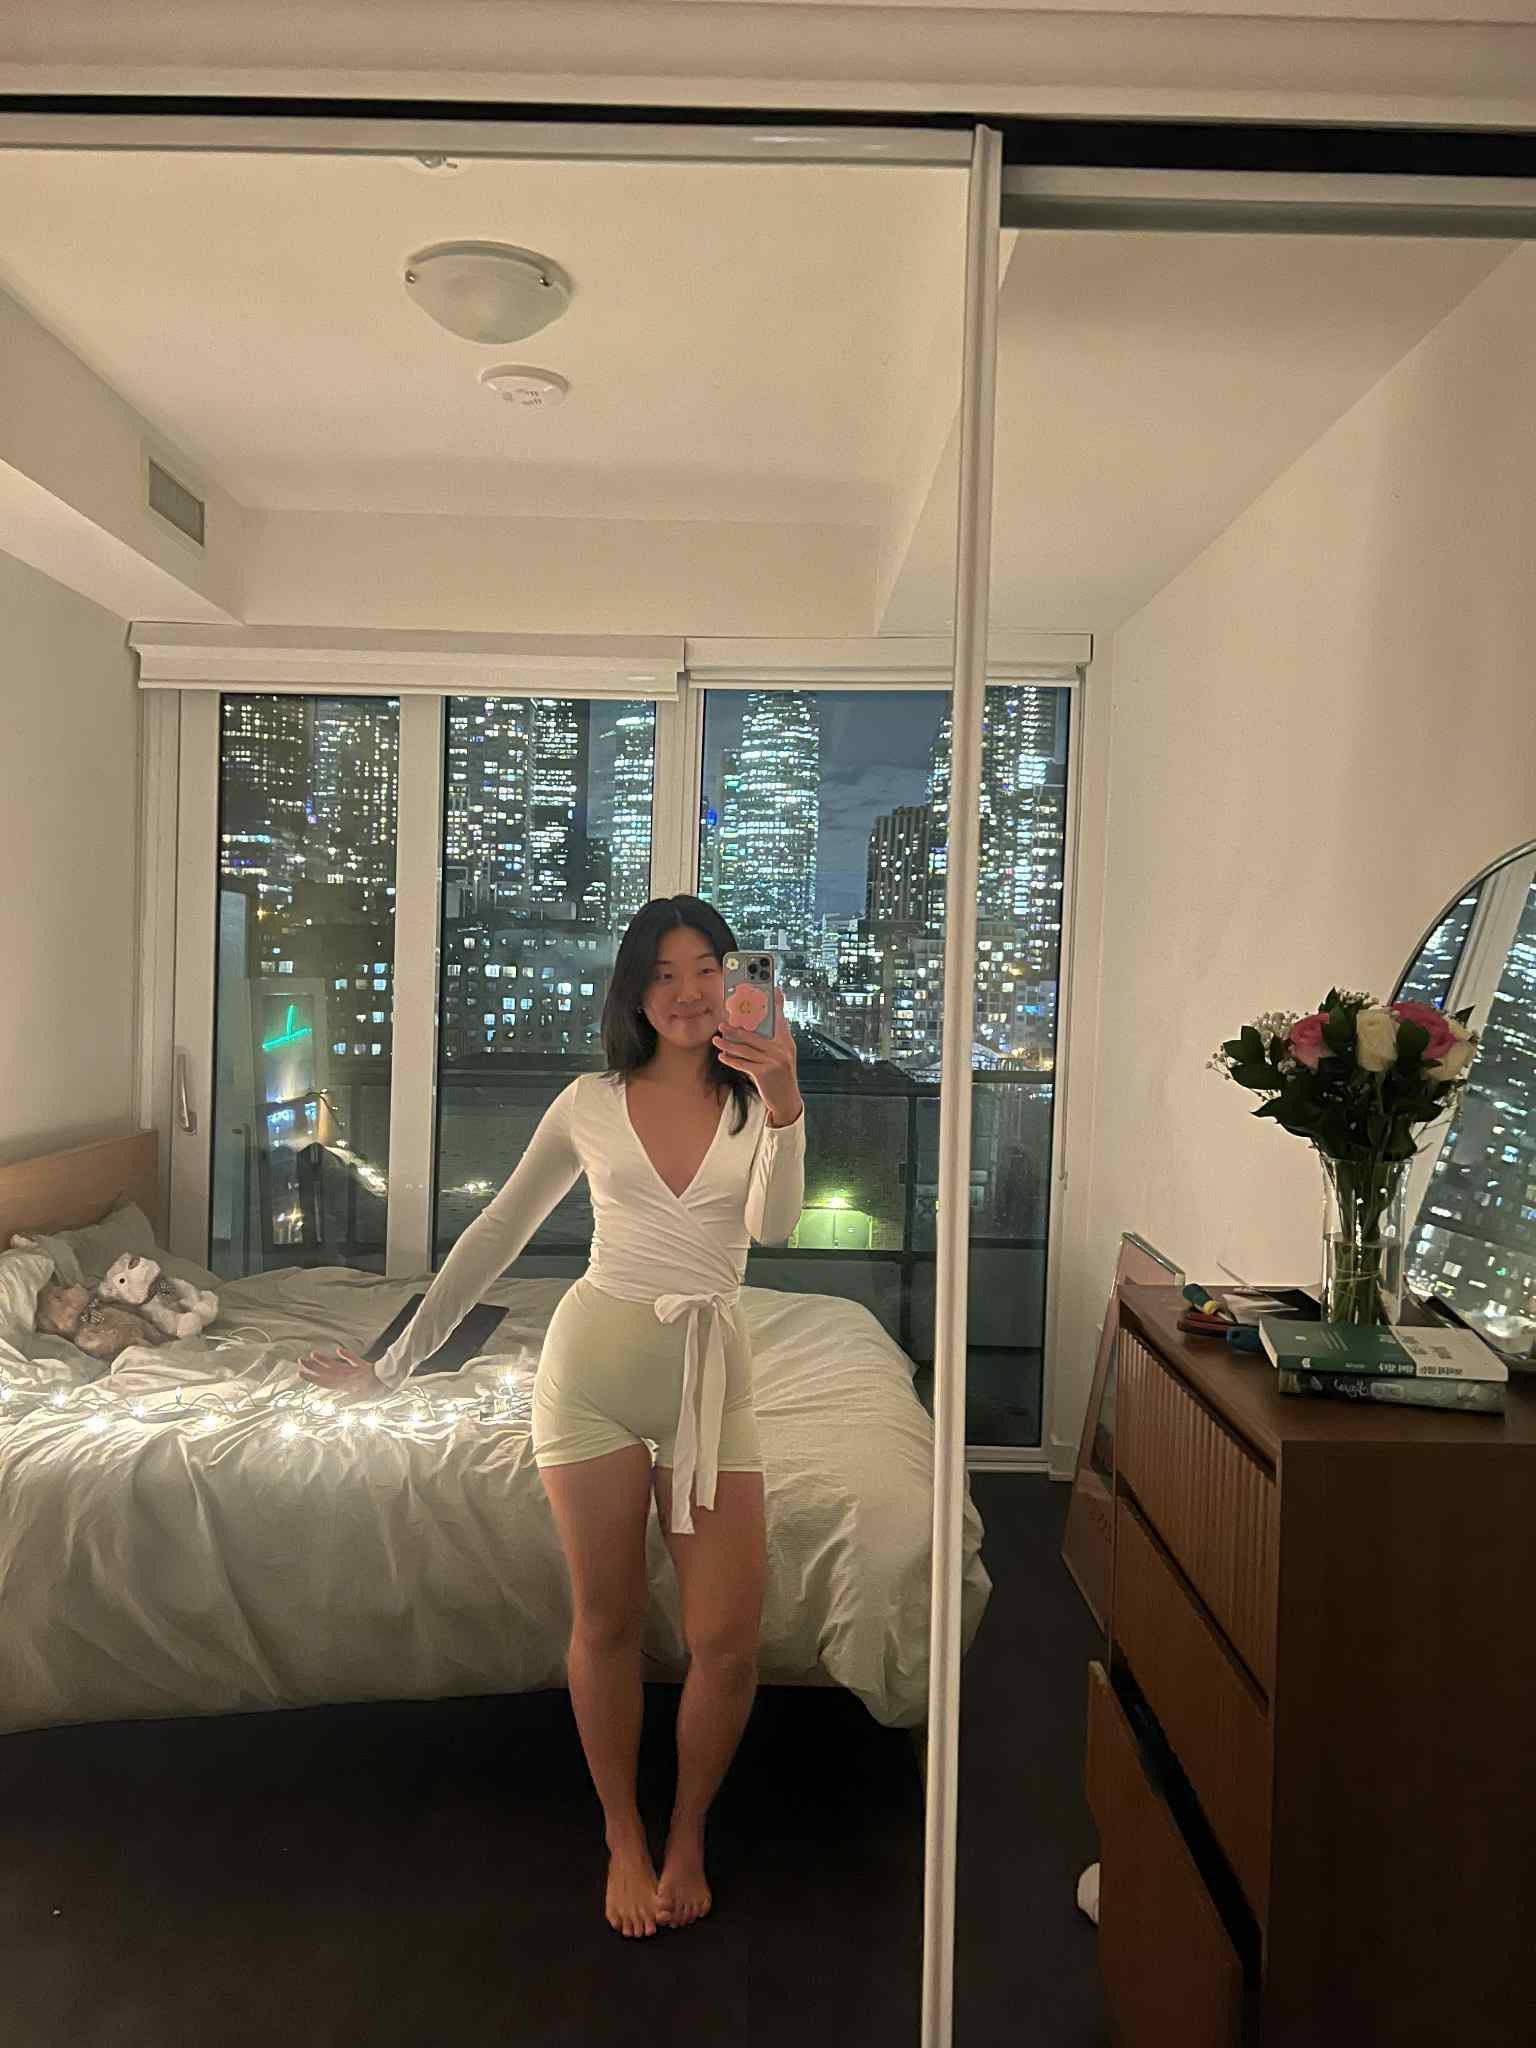


StyleLab extracted features:
body_aspect_ratio  = 3.7010
torso_leg_ratio    = 0.5988
shoulder_hip_ratio = 1.4000
joint_softness     = 0.7854


In [ ]:
# =========================================
# CELL 4 — Upload image → run pose → print features
# =========================================
import mediapipe as mp
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

uploaded = files.upload()
img_path = next(iter(uploaded.keys()))
img_bgr = cv2.imread(img_path)

cv2_imshow(img_bgr)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

mp_image = mp.Image(
    image_format=mp.ImageFormat.SRGB,
    data=img_rgb
)

result = detector.detect(mp_image)

if not result.pose_landmarks:
    raise ValueError("No pose detected — try a clearer full-body photo (standing, arms slightly away).")

features = extract_stylelab_features(result.pose_landmarks[0])

print("\nStyleLab extracted features:")
for k in ["body_aspect_ratio", "torso_leg_ratio", "shoulder_hip_ratio", "joint_softness"]:
    print(f"{k:18s} = {features[k]:.4f}")
